In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 17.5MB/s 
     |████████████████████████████████| 890kB 30.4MB/s 
     |████████████████████████████████| 1.1MB 40.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=92f5bde86e5ea972fd8d1a5b6cda819387d57f83284aff122517dd71626393c8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import xml.etree.ElementTree as ET

import torch
import pandas as pd
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchtext.data import Field, TabularDataset, BucketIterator

from torch.utils.data import Dataset

import spacy
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
list_of_comp= pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']

In [ ]:
list_of_comp = list(list_of_comp)

In [ ]:
other_index = ['ODP', 'SPY', 'spy',"AMPE",  "YHOO", "CSN", "SSYS" ]

In [ ]:
campanies_list = list_of_comp + other_index

In [ ]:
def tokenize_eng(text):
    return[tok.text for tok in nlp.tokenizer(text)]

In [ ]:
english = Field(sequential=True, use_vocab=True, tokenize = tokenize_eng, lower=True)

In [ ]:
sentiment = Field(sequential=False, use_vocab=False)

In [ ]:
fields={'text':("text", english), 'label':('label', sentiment)}

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
df = pd.read_csv("stock_sent.csv")

In [ ]:
df.columns = ['text','label']

In [ ]:
def filter_out_companies(sentence, campanies_list):
  temp = []
  for word in sentence.split(' '):
    if not word in list_of_comp and word[:4] != 'http' and  word[:1] != '#' :
      temp.append(word)
  return " ".join(temp)

In [ ]:
df['label'] = [1 if x == 1 else 0 for x in df['label'] ]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
df['text'] = [filter_out_companies(x,campanies_list ) for x in df['text']]

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
MAX_LEN = 80

In [ ]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,truncation=True,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
english.build_vocab(df_train, max_size=10000, min_freq=2)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((4632, 2), (579, 2), (580, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=5
  )

In [ ]:
BATCH_SIZE = 18
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.15)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
class_names = [0,1]

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
    ):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        model_save_name = 'best_model_state_smal11.bin'
        path = F"/content/gdrive/My Drive/my_drive/{model_save_name}"
        torch.save(model.state_dict(), path)
        best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.5614704961578051 accuracy 0.7074697754749568
Val   loss 0.4464430908362071 accuracy 0.8031088082901554

Epoch 2/3
----------
Train loss 0.3269504038256037 accuracy 0.8661485319516408
Val   loss 0.46181969739722484 accuracy 0.8203799654576857

Epoch 3/3
----------
Train loss 0.16473177494300717 accuracy 0.9475388601036269
Val   loss 0.6067705835131082 accuracy 0.8221070811744386

CPU times: user 4min 21s, sys: 2min 16s, total: 6min 38s
Wall time: 6min 46s


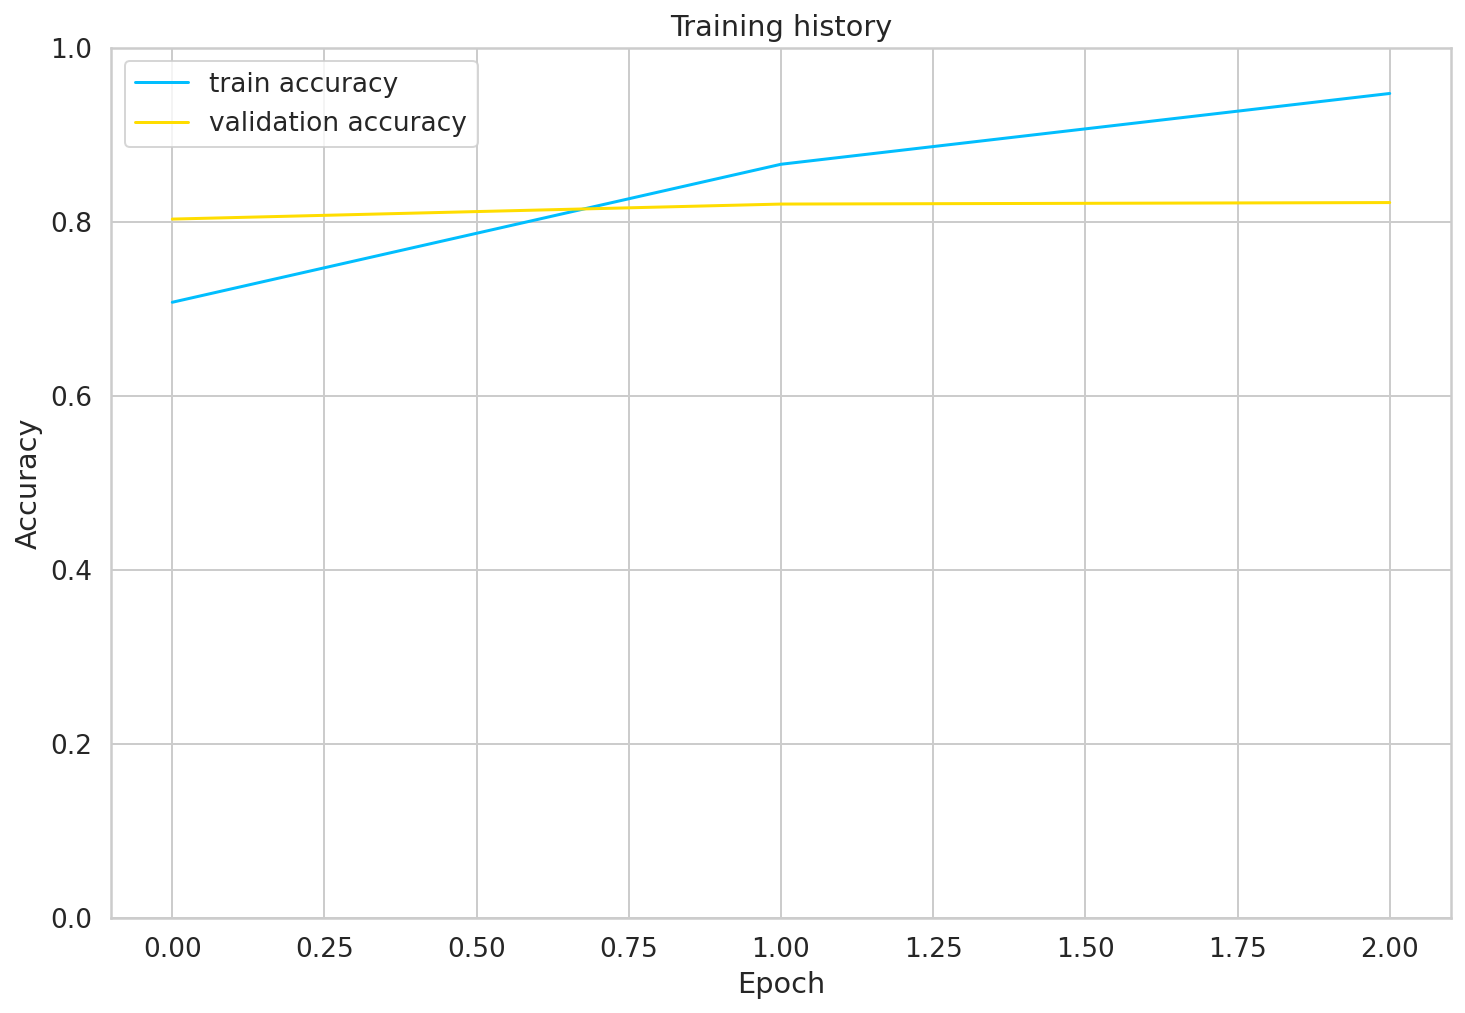

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8189655172413793